In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:


mnist_df = pd.read_csv('./data/train.csv')

X = mnist_df.drop('label', axis=1).to_numpy()
y = mnist_df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

In [3]:
class Model(nn.Module):
    def __init__(self, in_layer=784, hid1_layer=800, hid2_layer=130, hid3_layer=80, out_layer=10):
        super().__init__()
        self.fc1 = nn.Linear(in_layer, hid1_layer)
        self.fc2 = nn.Linear(hid1_layer, hid2_layer)
        self.fc3 = nn.Linear(hid2_layer, hid3_layer)
        self.out = nn.Linear(hid3_layer, out_layer)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        
        return x

In [4]:
model = Model()

In [5]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

In [6]:
epochs = 130
losses = []

for i in range(epochs):
    # Forward propagation
    y_pred = model.forward(X_train)

    # Measure loss
    loss = criterion(y_pred, y_train)

    # Keep track of losses
    losses.append(loss.detach().numpy())

    # Print every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}: loss = {loss}')

    
    # Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch 0: loss = 7.304249286651611
Epoch 10: loss = 1.2494852542877197
Epoch 20: loss = 0.5523138642311096
Epoch 30: loss = 0.41232573986053467
Epoch 40: loss = 0.29333603382110596
Epoch 50: loss = 0.28200116753578186
Epoch 60: loss = 0.1584978699684143
Epoch 70: loss = 0.13668061792850494
Epoch 80: loss = 0.11728327721357346
Epoch 90: loss = 0.10294828563928604
Epoch 100: loss = 0.10045936703681946
Epoch 110: loss = 0.0836932584643364
Epoch 120: loss = 0.07115218788385391


Text(0, 0.5, 'Loss')

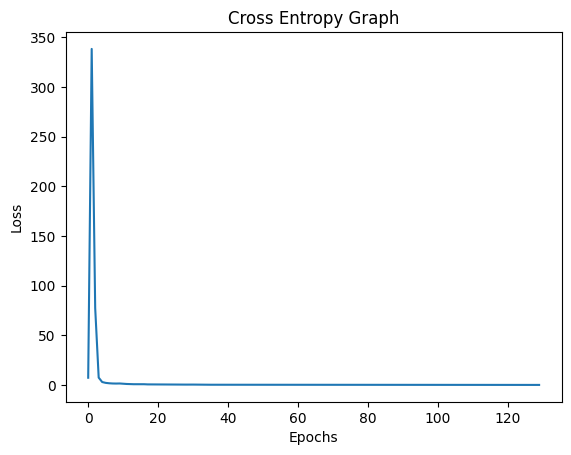

In [7]:
plt.plot(range(epochs), losses)
plt.title('Cross Entropy Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [8]:
with torch.no_grad():
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test) # get loss/error of y_eval

print(float(loss))

0.14077481627464294


In [14]:
def test_mnist(X_data, y_data):
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(X_data):
            y_val = model.forward(data)

            if (torch.argmax(y_val) == y_data[i]):
                correct +=  1

    return (correct/len(y_data)) * 100

In [16]:
print(f'Training Data Accuracy:\t {test_mnist(X_train, y_train):.2f}%')
print(f'Test Data Accuracy:\t {test_mnist(X_test, y_test):.2f}%')

Training Data Accuracy:	 97.87%
Test Data Accuracy:	 95.70%
